In [42]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
# Config
batch_size = 100
n_iters = 20000
num_epochs = None

input_dim = 784
hidden_dim = 400
latent_dim = 200
output_dim = input_dim

lr = 1e-3


4


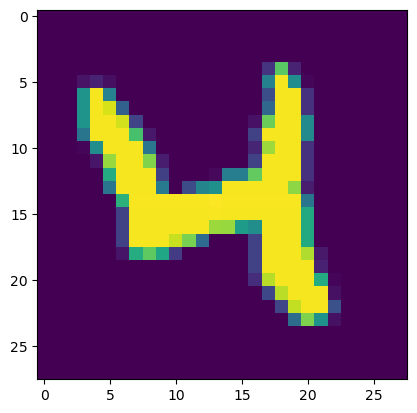

In [45]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

sample_num = 20
img = train_dataset[sample_num][0].reshape(28,28)
print(train_dataset[sample_num][1])
plt.imshow(img)

In [46]:
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [47]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(.2)
    
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):
        epsilon = torch.rand_like(var).to(device)
        z = mean + var*epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparametrization(mean, torch.exp(0.5*log_var))
        x_hat = self.decoder(z)

        return x_hat, mean, log_var

encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)
model = VAE(encoder, decoder).to(device)
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reconst_loss = nn.functional.binary_cross_entropy(x_hat, x, reduce='sum')
    KLD = -.5 * torch.sum(1+log_var-mean.pow(2)-log_var.exp())
    return reconst_loss + KLD

optim = torch.optim.Adam(model.parameters(), lr=lr)

In [48]:
for epoch in range(num_epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_dataloader):
        x = x.view(-1, 28*28).to(device)

        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optim.step()

    print(f'Epoch:{epoch}, avg loss:{overall_loss}')

/home/mrj/miniconda3/envs/nn/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch:0, avg loss:264.6445827782154
Epoch:1, avg loss:162.83932647109032
Epoch:2, avg loss:160.15942692756653
Epoch:3, avg loss:159.58795884251595
Epoch:4, avg loss:158.95473040640354
Epoch:5, avg loss:158.77380849421024
Epoch:6, avg loss:158.59180283546448
Epoch:7, avg loss:158.6359853297472
Epoch:8, avg loss:158.32604917883873
Epoch:9, avg loss:158.29273223876953
Epoch:10, avg loss:158.19679939746857
Epoch:11, avg loss:158.14864215254784
Epoch:12, avg loss:158.0846815854311
Epoch:13, avg loss:158.05240139365196
Epoch:14, avg loss:158.0303230136633
Epoch:15, avg loss:157.99555312097073
Epoch:16, avg loss:157.97663432359695
Epoch:17, avg loss:1604.3392636924982
Epoch:18, avg loss:162.50142535567284
Epoch:19, avg loss:161.85778848826885
Epoch:20, avg loss:168.72928020358086
Epoch:21, avg loss:172.13600951433182
Epoch:22, avg loss:165.34041607379913
Epoch:23, avg loss:162.27767869830132
Epoch:24, avg loss:164.82256346940994
Epoch:25, avg loss:162.1330364048481
Epoch:26, avg loss:168.6171

In [49]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

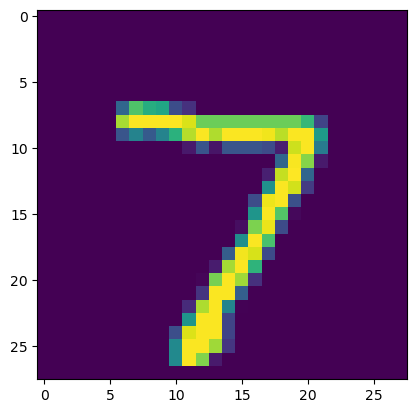

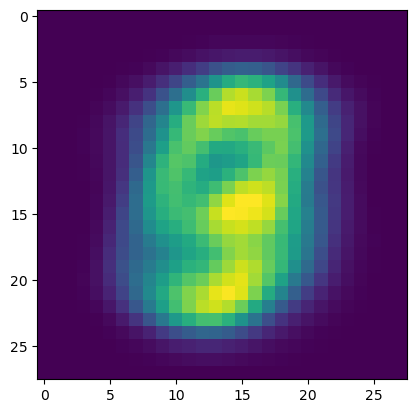

In [50]:
with torch.no_grad():
    for i, (x, _) in enumerate(test_dataloader):
        x = x.view(-1, 28*28)
        x = x.to(device)

        x_hat, _, _ = model(x)

        break
show_image(x, idx=0)
show_image(x_hat, idx=0)

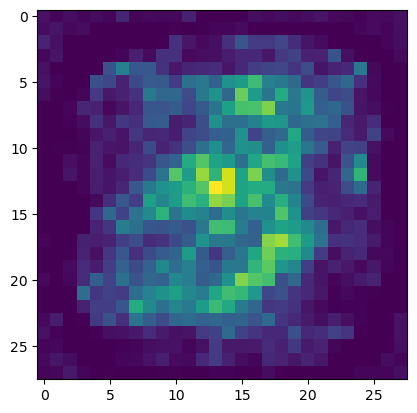

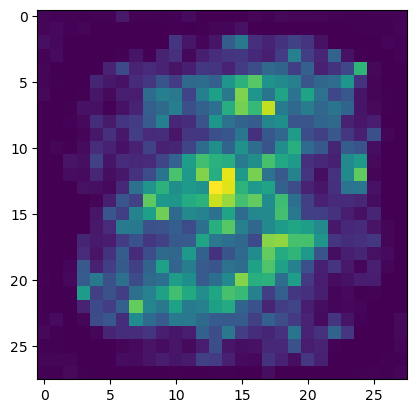

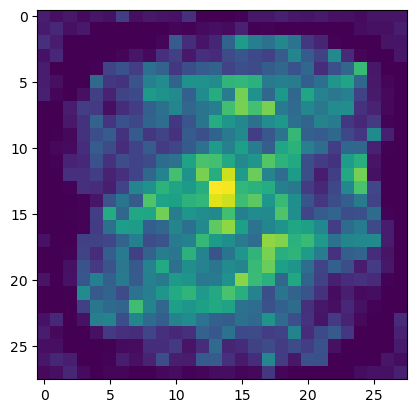

In [51]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

show_image(generated_images, idx=0)
show_image(generated_images, idx=12)
show_image(generated_images, idx=25)
